# First-order all-pass filter

The first building block of a warped linear prediction filter is a first-order all-pass filter. Let's begin with its transfer function ([[1]](#References)):

$$D(z) = \frac{z^{-1} - \lambda}{1 - \lambda z^{-1}}$$

By setting λ = 0, this reduces to a unit delay:

$$D(z) = z^{-1}$$

Unit delay, i.e. multiplying by z<sup>-1</sup> in the z-domain, implies a lag of 1 sample in the discrete time domain ([[2]](#References)):
$$y[n] = D(z)x[n] \implies y[n] = x[n-1]$$

Let's observe this in practice.

In [1]:
import numpy, scipy, scipy.signal

b = [0, 1]
a = [1, 0]

w, h = scipy.signal.freqz(b, a)

`b` and `a` are the numerator and denominator coefficients of the filter's transfer function ([[3]](#References)) in terms of z<sup>-1</sup>, and are common arguments for filter-related functions in scipy (e.g. freqz, lfilter):

$$D(z) = z^{-1} = \frac{0z^{0} + 1z^{-1} + 0z^{-2} + ...}{1z^{0} - 0z^{-1} + 0z^{-2} + ...} \implies \frac{[0, 1]}{[1, 0]}$$

Let's see some plots ([[4]](#References)) to describe the behavior of the unit delay above (i.e. a first-order all-pass filter with λ = 0):

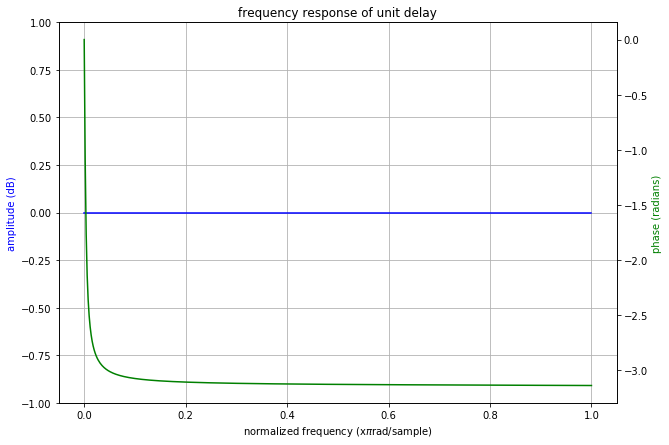

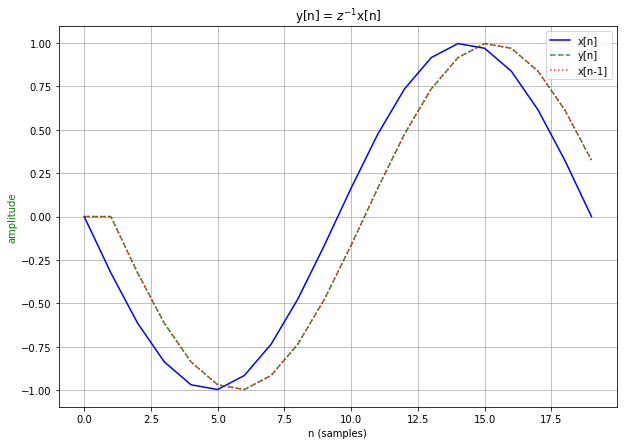

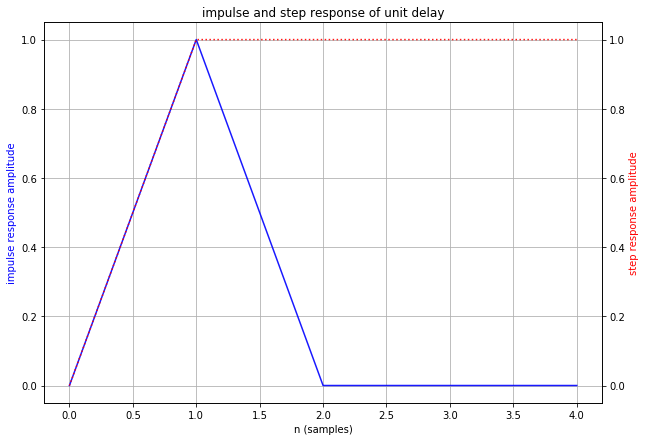

In [6]:
import matplotlib.pyplot as plt

fig1, ax11 = plt.subplots(figsize=(10, 7))
plt.title('frequency response of unit delay')
plt.plot(w/max(w), 20 * numpy.log10(abs(h)), 'b')
plt.ylim(-1, 1)
plt.ylabel('amplitude (dB)', color='b')
plt.xlabel(r'normalized frequency (x$\pi$rad/sample)')
ax11.grid()
ax21 = ax11.twinx()
angles = numpy.unwrap(numpy.angle(h))
plt.plot(w/max(w), angles, 'g')
plt.ylabel('phase (radians)', color='g')
plt.axis('tight')

x = numpy.sin(numpy.linspace(-numpy.pi, numpy.pi, 20))
y1 = scipy.signal.lfilter(b, a, x)
y2 = numpy.append([0], x[:-1])
samples = numpy.arange(max(max(len(x), len(y1)), len(y2)))

fig2, ax2 = plt.subplots(figsize=(10, 7))
plt.title(r'y[n] = $z^{-1}$x[n]')
plt.plot(samples, x, 'b', label='x[n]')
plt.plot(samples, y1, 'g', linestyle='--', alpha=0.8, label='y[n]')
plt.plot(samples, y2, 'r', linestyle=':', alpha=0.8, label='x[n-1]')
plt.xlabel('n (samples)')
plt.ylabel('amplitude', color='g')
ax2.grid()
ax2.legend(loc='upper right')

fig3, ax3 = plt.subplots(figsize=(10, 7))
plt.title('impulse and step response of unit delay')
l = 5
x_axis = numpy.arange(l)
impulse = numpy.zeros(l); impulse[0] = 1.0
impulse_response = scipy.signal.lfilter(b, a, impulse)
plt.plot(x_axis, impulse_response, color='b', alpha=0.9)
plt.ylabel('impulse response amplitude', color='b')
plt.xlabel('n (samples)')
ax4 = ax3.twinx()
step_response = numpy.cumsum(impulse_response)
plt.plot(x_axis, step_response, color='r', linestyle=':', alpha=0.9)
plt.ylabel('step response amplitude', color='r')
ax3.grid()

plt.axis('tight')
plt.show()

The flat frequency response is expected - an all-pass filter passes all frequencies equally. The phase response drops to -pi (-180°). What does that mean? Let's go back to the term mentioned earlier - unit delay, i.e.:

$$y[n] = D(z)x[n] \implies y[n] = x[n-1]$$

Given that the normalized Nyquist frequency is π radians/sample, and the above graph is in terms of normalized frequency, a delay of 1 sample, i.e. -1 sample, is equivalent to a -pi radian phase shift.

## Varying λ

λ is also known as the warping factor ([[5]](#References)), limited to |λ| < 1 for stability ([[6]](#References)):

$$-1 < \lambda < 1 \implies \left|\lambda\right| < 1$$

>Positive values of λ enhance the resolution (equalization) at low frequencies while negative values of λ enhance the resolution at high frequencies ([[7]](#References))

Let's create the frequency, step, and impulse response plots again, with a varying lambda.

First, we should derive the new `b` and `a` arrays:

$$D(z) = \frac{z^{-1} - \lambda}{1 - \lambda z^{-1}} = \frac{- \lambda z^{0} + 1z^{-1} + 0z^{-2} + ...}{1z^{0} - \lambda z^{-1} + 0z^{-2} + ...} \implies \frac{[-\lambda, 1]}{[1, -\lambda]}$$

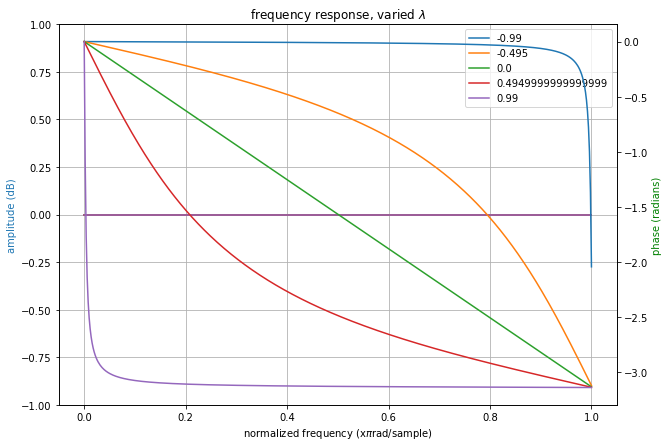

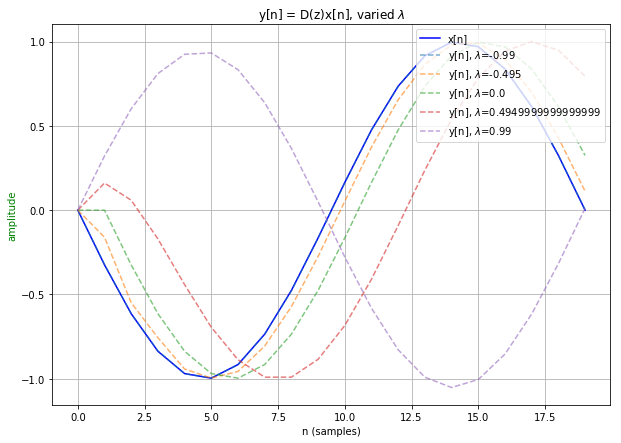

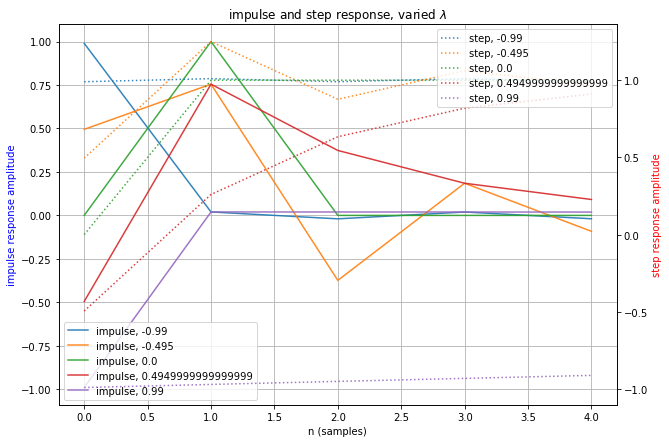

In [9]:
warp_factors = numpy.linspace(-0.99, 0.99, 5)

fig1, ax11 = plt.subplots(figsize=(10, 7))
ax11.grid()
plt.title(r'frequency response, varied $\lambda$')
plt.ylim(-1, 1)
plt.ylabel('amplitude (dB)', color='C0')
plt.xlabel(r'normalized frequency (x$\pi$rad/sample)')

for i, wf in enumerate(warp_factors):
    w, h = scipy.signal.freqz([-wf, 1.0], [1.0, -wf])
    ax11.plot(w/max(w), 20 * numpy.log10(abs(h)), 'C{0}'.format(i), label=wf)
    
ax21 = ax11.twinx()
plt.ylabel('phase (radians)', color='g')

for i, wf in enumerate(warp_factors):
    w, h = scipy.signal.freqz([-wf, 1.0], [1.0, -wf])
    angles = numpy.unwrap(numpy.angle(h))
    ax21.plot(w/max(w), angles, 'C{0}'.format(i), label=wf)

ax11.legend(loc='upper right')

x = numpy.sin(numpy.linspace(-numpy.pi, numpy.pi, 20))
samples = numpy.arange(len(x))

fig2, ax2 = plt.subplots(figsize=(10, 7))
plt.title(r'y[n] = D(z)x[n], varied $\lambda$')
plt.plot(samples, x, 'b', label='x[n]')
plt.xlabel('n (samples)')
plt.ylabel('amplitude', color='g')

for i, wf in enumerate(warp_factors):
    y = scipy.signal.lfilter([-wf, 1.0], [1.0, -wf], x)
    plt.plot(samples, y, 'C{0}'.format(i), linestyle='--', alpha=0.6, label=r'y[n], $\lambda$={0}'.format(wf))

ax2.grid()
plt.legend(loc='upper right')

fig3, ax3 = plt.subplots(figsize=(10, 7))
plt.title(r'impulse and step response, varied $\lambda$')
l = 5
x_axis = numpy.arange(l)
impulse = numpy.zeros(l); impulse[0] = 1.0
plt.xlabel('n (samples)')
plt.ylabel('impulse response amplitude', color='b')

for i, wf in enumerate(warp_factors):
    impulse_response = scipy.signal.lfilter([-wf, 1.0], [1.0, -wf], impulse)
    plt.plot(x_axis, impulse_response, label='impulse, {0}'.format(wf), color='C{0}'.format(i), alpha=0.9)

plt.legend(loc='lower left')
ax4 = ax3.twinx()
plt.ylabel('step response amplitude', color='r')

for i, wf in enumerate(warp_factors):
    impulse_response = scipy.signal.lfilter([-wf, 1.0], [1.0, -wf], impulse)
    step_response = numpy.cumsum(impulse_response)
    plt.plot(x_axis, step_response, label='step, {0}'.format(wf), color='C{0}'.format(i), linestyle=':', alpha=0.9)
    
ax3.grid()
plt.legend(loc='upper right')

plt.axis('tight')
plt.show()

## References

1. Harma A, Laine U. K., "A comparison of warped and conventional linear predictive coding," EDICS

2. Schuller G., "z-Transform, Filters,", Digital Signal Processing 2/ Advanced Digital Signal Processing Lecture 7, TU-Ilmenau

3. SciPy documentation, "scipy.signal.freqz," https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html

4. Pastell M, "FIR filter design with Python and SciPy," http://mpastell.com/pweave/_downloads/FIR_design_rst.html

5. P. Esquef, M. Karjalainen and V. Valimaki, "Detection of clicks in audio signals using warped linear prediction," 2002 14th International Conference on Digital Signal Processing Proceedings. DSP 2002 (Cat. No.02TH8628), Santorini, Greece, 2002, pp. 1085-1088 vol.2.

6. Surges, Greg & Smyth, Tamara. (2013). "Spectral Distortion Using Second-Order Allpass Filters"

7. Peng, Wang & Ser, Wee & Zhang, Ming. (2001). "Bark Scale Equalizer Design Using Warped Filter," 5.10.1109/ICASSP.2001.940368.